# Load Data

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [2]:
# reflect database table into classes
engine = create_engine("sqlite:///db/kickstarter_campaigns.sqlite", echo=False)

Base = automap_base()
Base.prepare(engine, reflect=True)
Kickstarter = Base.classes.kickstarter_campaigns

session = Session(engine)

In [3]:
# load data from db
data = engine.execute('SELECT * FROM kickstarter_campaigns')
kickstarter_df = pd.DataFrame()
record_list = []
for record in data:
    record_list.append(record)
    
kickstarter_df = pd.DataFrame(record_list)
kickstarter_df.columns = ['index','backers_count','blurb','country','currency','deadline','fx_rate','goal','id',
                          'name','pledged','slug','state','category_id','category_name','parent_category_id',
                          'creator_profile','creator_name','start_date','campaign_length','month_started','state_or_province',
                          'parent_category','blurb_length','blurb_sentiment_compound','blurb_sentiment_positive',
                          'blurb_sentiment_negative','blurb_sentiment_neutral','title_length','title_sentiment_compound',
                          'title_sentiment_positive','title_sentiment_negative','title_sentiment_neutral','usd_goal',
                          'pct_complete']

kickstarter_df = kickstarter_df.drop(['index'], axis=1)
kickstarter_df = kickstarter_df.reset_index()
kickstarter_df = kickstarter_df.drop(['index'], axis=1)

print(f'{len(kickstarter_df)} rows of data loaded')
kickstarter_df.head()

188137 rows of data loaded


,backers_count,blurb,country,currency,deadline,fx_rate,goal,id,name,pledged,...,blurb_sentiment_positive,blurb_sentiment_negative,blurb_sentiment_neutral,title_length,title_sentiment_compound,title_sentiment_positive,title_sentiment_negative,title_sentiment_neutral,usd_goal,pct_complete
0,80,I will be an artist-in-residence at Elsewhere ...,US,USD,2012-04-19 15:16:00,1.0,2800.0,1562040083,Elsewhere Studios artist-in-residency program!,3596.0,...,0.000,0.0,1.000,46,0.0,0.0,0.0,1.0,2800.0,1.284286
1,47,We are looking to bring a Visiting Sculptor fr...,US,USD,2012-04-20 17:06:38,1.0,3900.0,1437561817,Martin Luther King Jr. Sculpture on Campus!,4117.0,...,0.084,0.0,0.916,43,0.0,0.0,0.0,1.0,3900.0,1.055641
2,80,Surrealistic oil paintings capturing the metam...,US,USD,2012-04-16 22:59:00,1.0,750.0,574125813,EMERGENCE: Surreal Oil Paintings by J.J. Long,3125.0,...,0.000,0.0,1.000,45,0.0,0.0,0.0,1.0,750.0,4.166667
3,82,1000 Artists is a public art-making installati...,US,USD,2012-05-07 20:22:25,1.0,4500.0,858990141,1000 Artists: Presidential Inauguration 2013,4586.0,...,0.000,0.0,1.000,44,0.0,0.0,0.0,1.0,4500.0,1.019111
4,31,P.M.A.F.T.W. my upcoming solo show June 2012 a...,US,USD,2012-04-02 21:57:23,1.0,1000.0,566704999,P.M.A.F.T.W.,1036.0,...,0.000,0.0,1.000,12,0.0,0.0,0.0,1.0,1000.0,1.036000


In [4]:
# drop canceled campaigns
old_len = len(kickstarter_df)

success_df = kickstarter_df[kickstarter_df.state == 'successful']
failure_df = kickstarter_df[kickstarter_df.state == 'failed']
dfs = [success_df, failure_df]
kickstarter_df = pd.concat(dfs)

new_len = len(kickstarter_df)
print(f'{old_len - new_len} canceled campaigns dropped')

8823 canceled campaigns dropped


# Create ML Models

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical

Using TensorFlow backend.


In [6]:
# create dictionaries to encode categorical features
country_list = list(set(kickstarter_df['country']))
country_dic = {}
for i in range(0, len(country_list)):
    country_dic[country_list[i]] = i
    
currency_list = list(set(kickstarter_df['currency']))
currency_dic = {}
for i in range(0, len(currency_list)):
    currency_dic[currency_list[i]] = i
    
category_name_list = list(set(kickstarter_df['category_name']))
category_name_dic = {}
for i in range(0, len(category_name_list)):
    category_name_dic[category_name_list[i]] = i
    
parent_category_list = list(set(kickstarter_df['parent_category']))
parent_category_dic = {}
for i in range(0, len(parent_category_list)):
    parent_category_dic[parent_category_list[i]] = i
    
month_list = list(set(kickstarter_df['month_started']))
month_dic = {}
for i in range(0, len(month_list)):
    month_dic[month_list[i]] = i

country_encoded_list = []
currency_encoded_list = []
category_encoded_list = []
parent_category_encoded_list = []
month_encoded_list = []

for i in range(0, len(kickstarter_df['country'])):
    country_encoded = country_dic[kickstarter_df['country'][i]]
    country_encoded_list.append(country_encoded)
    category_encoded = category_name_dic[kickstarter_df['category_name'][i]]
    category_encoded_list.append(category_encoded)
    parent_category_encoded = parent_category_dic[kickstarter_df['parent_category'][i]]
    parent_category_encoded_list.append(parent_category_encoded)
    currency_encoded = currency_dic[kickstarter_df['currency'][i]]
    currency_encoded_list.append(currency_encoded)
    month_encoded = month_dic[kickstarter_df['month_started'][i]]
    month_encoded_list.append(month_encoded)

In [7]:
# add encoded categorical features to dataframe
kickstarter_df['country_encoded'] = country_encoded_list
kickstarter_df['currency_encoded'] = currency_encoded_list
kickstarter_df['category_encoded'] = category_encoded_list
kickstarter_df['parent_category_encoded'] = parent_category_encoded_list
kickstarter_df['month_encoded'] = month_encoded_list
kickstarter_df.head()

,backers_count,blurb,country,currency,deadline,fx_rate,goal,id,name,pledged,...,title_sentiment_positive,title_sentiment_negative,title_sentiment_neutral,usd_goal,pct_complete,country_encoded,currency_encoded,category_encoded,parent_category_encoded,month_encoded
0,80,I will be an artist-in-residence at Elsewhere ...,US,USD,2012-04-19 15:16:00,1.0,2800.0,1562040083,Elsewhere Studios artist-in-residency program!,3596.0,...,0.0,0.0,1.0,2800.0,1.284286,12,5,52,13,6
1,47,We are looking to bring a Visiting Sculptor fr...,US,USD,2012-04-20 17:06:38,1.0,3900.0,1437561817,Martin Luther King Jr. Sculpture on Campus!,4117.0,...,0.0,0.0,1.0,3900.0,1.055641,12,5,84,2,6
2,80,Surrealistic oil paintings capturing the metam...,US,USD,2012-04-16 22:59:00,1.0,750.0,574125813,EMERGENCE: Surreal Oil Paintings by J.J. Long,3125.0,...,0.0,0.0,1.0,750.0,4.166667,12,5,154,13,6
3,82,1000 Artists is a public art-making installati...,US,USD,2012-05-07 20:22:25,1.0,4500.0,858990141,1000 Artists: Presidential Inauguration 2013,4586.0,...,0.0,0.0,1.0,4500.0,1.019111,12,5,51,13,6
4,31,P.M.A.F.T.W. my upcoming solo show June 2012 a...,US,USD,2012-04-02 21:57:23,1.0,1000.0,566704999,P.M.A.F.T.W.,1036.0,...,0.0,0.0,1.0,1000.0,1.036000,12,5,154,13,6


In [8]:
# define datasets (one including the backer county and one excluding)

X = kickstarter_df.drop(['blurb','country','currency','deadline','fx_rate','id','name','slug','state',
                         'category_id','category_name','parent_category_id','creator_profile',
                         'creator_name', 'start_date', 'month_started','state_or_province','parent_category',
                         'backers_count','pledged', 'pct_complete', 'goal'], axis=1)
              
X_backers = kickstarter_df.drop(['blurb','country','currency','deadline','fx_rate','id','name','slug','state',
                         'category_id','category_name','parent_category_id','creator_profile',
                         'creator_name', 'start_date', 'month_started','state_or_province','parent_category',
                         'pledged', 'pct_complete', 'goal'], axis=1)
              
y = kickstarter_df['state']

In [9]:
X.head()

,campaign_length,blurb_length,blurb_sentiment_compound,blurb_sentiment_positive,blurb_sentiment_negative,blurb_sentiment_neutral,title_length,title_sentiment_compound,title_sentiment_positive,title_sentiment_negative,title_sentiment_neutral,usd_goal,country_encoded,currency_encoded,category_encoded,parent_category_encoded,month_encoded
0,21.96,118,0.0000,0.000,0.0,1.000,46,0.0,0.0,0.0,1.0,2800.0,12,5,52,13,6
1,23.00,135,0.2732,0.084,0.0,0.916,43,0.0,0.0,0.0,1.0,3900.0,12,5,84,2,6
2,19.21,90,0.0000,0.000,0.0,1.000,45,0.0,0.0,0.0,1.0,750.0,12,5,154,13,6
3,40.00,117,0.0000,0.000,0.0,1.000,44,0.0,0.0,0.0,1.0,4500.0,12,5,51,13,6
4,5.00,61,0.0000,0.000,0.0,1.000,12,0.0,0.0,0.0,1.0,1000.0,12,5,154,13,6


In [10]:
X_backers.head()

,backers_count,campaign_length,blurb_length,blurb_sentiment_compound,blurb_sentiment_positive,blurb_sentiment_negative,blurb_sentiment_neutral,title_length,title_sentiment_compound,title_sentiment_positive,title_sentiment_negative,title_sentiment_neutral,usd_goal,country_encoded,currency_encoded,category_encoded,parent_category_encoded,month_encoded
0,80,21.96,118,0.0000,0.000,0.0,1.000,46,0.0,0.0,0.0,1.0,2800.0,12,5,52,13,6
1,47,23.00,135,0.2732,0.084,0.0,0.916,43,0.0,0.0,0.0,1.0,3900.0,12,5,84,2,6
2,80,19.21,90,0.0000,0.000,0.0,1.000,45,0.0,0.0,0.0,1.0,750.0,12,5,154,13,6
3,82,40.00,117,0.0000,0.000,0.0,1.000,44,0.0,0.0,0.0,1.0,4500.0,12,5,51,13,6
4,31,5.00,61,0.0000,0.000,0.0,1.000,12,0.0,0.0,0.0,1.0,1000.0,12,5,154,13,6


In [11]:
# scale data
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

X_backers_scaler = StandardScaler().fit(X_backers)
X_backers_scaled = X_backers_scaler.transform(X_backers)

In [12]:
# encode outputs
y_label_encoder = LabelEncoder()
y_label_encoder.fit(y)
y_encoded = y_label_encoder.transform(y)
y_categorical = to_categorical(y_encoded)

In [13]:
#create dataframe to store model results
results_df = pd.DataFrame()

In [14]:
#split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_backers_train, X_backers_test, y_backers_train, y_backers_test = train_test_split(X_backers, y, random_state=42)

# Random Forest

In [15]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)

rf_backers = RandomForestClassifier(n_estimators=200)
rf_backers = rf_backers.fit(X_backers_train, y_backers_train)
rf_backers_train_score = rf_backers.score(X_backers_train, y_backers_train)
rf_backers_test_score = rf_backers.score(X_backers_test, y_backers_test)

In [16]:
# check feature importances
importances = rf.feature_importances_
print(sorted(zip(rf.feature_importances_, X.columns), reverse=True))
importances = rf_backers.feature_importances_
print(sorted(zip(rf_backers.feature_importances_, X_backers.columns), reverse=True))

[(0.16797017960091945, 'category_encoded'), (0.12800454909856768, 'usd_goal'), (0.09913309137695292, 'parent_category_encoded'), (0.085658466244535519, 'title_length'), (0.079468817770848826, 'campaign_length'), (0.07701396957147201, 'blurb_length'), (0.061077151977111409, 'blurb_sentiment_compound'), (0.058531689489225699, 'blurb_sentiment_neutral'), (0.054993488355428298, 'month_encoded'), (0.054789050651981162, 'blurb_sentiment_positive'), (0.025178655544229458, 'title_sentiment_compound'), (0.024096680854847233, 'title_sentiment_neutral'), (0.021700157855538551, 'blurb_sentiment_negative'), (0.020186846498010308, 'title_sentiment_positive'), (0.017148515519700206, 'country_encoded'), (0.016328449973712255, 'currency_encoded'), (0.0087202396169190951, 'title_sentiment_negative')]
[(0.64090048142638811, 'backers_count'), (0.11830967751955641, 'usd_goal'), (0.039109448419633729, 'category_encoded'), (0.038259580806284714, 'parent_category_encoded'), (0.02309185212903718, 'title_length

In [17]:
results_df = results_df.append({"model":"random_forest",
                                "train_score":rf_train_score,
                                "test_score":rf_test_score,
                                "train_score_backers":rf_backers_train_score,
                                "test_score_backers":rf_backers_test_score}, 
                               ignore_index=True)
results_df

,model,test_score,test_score_backers,train_score,train_score_backers
0,random_forest,0.783555,0.950032,0.999985,1.0


In [34]:
# save model

from sklearn.externals import joblib
model_name = 'random_forest'
joblib.dump(rf, f'models/{model_name}.pkl') 

model_name_backers = 'random_forest_backers'
joblib.dump(rf_backers, f'models/{model_name_backers}.pkl') 

['models/random_forest_backers.pkl']

In [35]:
loaded_model = joblib.load(f'models/{model_name}.pkl')
loaded_model_backers = joblib.load(f'models/{model_name_backers}.pkl')

In [38]:
print(f'without backers: {loaded_model.score(X_test, y_test)}')
print(f'with backers: {loaded_model_backers.score(X_backers_test, y_backers_test)}')

without backers: 0.7835552878716902
with backers: 0.9500323451337304


# Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
lr_train_score = classifier.score(X_train, y_train)
lr_test_score = classifier.score(X_test, y_test)

classifier_backers = LogisticRegression()
classifier_backers.fit(X_backers_train, y_backers_train)
lr_backers_train_score = classifier_backers.score(X_backers_train, y_backers_train)
lr_backers_test_score = classifier_backers.score(X_backers_test, y_backers_test)

In [22]:
results_df = results_df.append({"model":"logistic_regression",
                                "train_score":lr_train_score,
                                "test_score":lr_test_score,
                                "train_score_backers":lr_backers_train_score,
                                "test_score_backers":lr_backers_test_score}, 
                               ignore_index=True)
results_df

,model,test_score,test_score_backers,train_score,train_score_backers
0,random_forest,0.783555,0.950032,0.999985,1.000000
1,logistic_regression,0.641259,0.931272,0.644161,0.930639


# K Nearest Neighbors

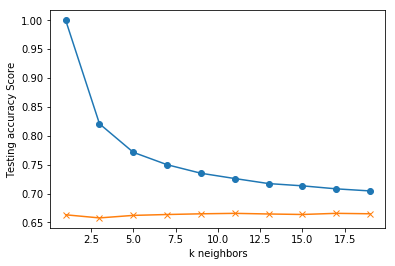

In [23]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

train_scores = []
test_scores = []

for k in range(1,20,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)

plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

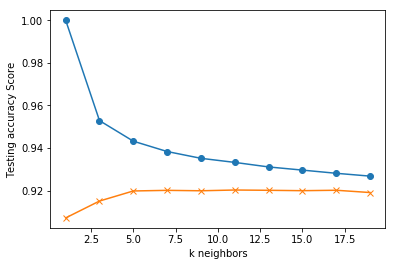

In [24]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

train_backers_scores = []
test_backers_scores = []

for k in range(1,20,2):
    knn_backers = KNeighborsClassifier(n_neighbors=k)
    knn_backers.fit(X_backers_train, y_backers_train)
    train_backers_score = knn_backers.score(X_backers_train, y_backers_train)
    test_backers_score = knn_backers.score(X_backers_test, y_backers_test)
    train_backers_scores.append(train_backers_score)
    test_backers_scores.append(test_backers_score)

plt.plot(range(1, 20, 2), train_backers_scores, marker='o')
plt.plot(range(1, 20, 2), test_backers_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [25]:
results_df = results_df.append({"model":"k_nearest_neigbors_9",
                                "train_score":train_scores[3],
                                "test_score":test_scores[3],
                                "train_score_backers":train_backers_scores[3],
                                "test_score_backers":test_backers_scores[3]}, 
                               ignore_index=True)
results_df

,model,test_score,test_score_backers,train_score,train_score_backers
0,random_forest,0.783555,0.950032,0.999985,1.000000
1,logistic_regression,0.641259,0.931272,0.644161,0.930639
2,k_nearest_neigbors_9,0.663767,0.920163,0.749950,0.938387


# SVM

In [26]:
# from sklearn.svm import SVC

# model = SVC(kernel='linear')
# model.fit(X_train, y_train)

# svm_train_score = model.score(X_train, y_train)
# svm_test_score = model.score(X_test, y_test)

In [27]:
# results_df = results_df.append({"model":"svm",
#                                 "train_score":svm_train_score,
#                                 "test_score":svm_test_score}, 
#                                ignore_index=True)
# results_df

# Neural Networks

In [28]:
X_train, X_test, y_cat_train, y_cat_test = train_test_split(X, y_categorical, random_state=42)
X_backers_train, X_backers_test, y_backers_cat_train, y_backers_cat_test = train_test_split(X_backers, y_categorical, random_state=42)

In [30]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=17))
model.add(Dense(units=300, activation='relu'))
model.add(Dense(units=2,activation="softmax"))

model.compile(optimizer='adam',
             loss='mean_squared_error',
             metrics=['accuracy'])

model.fit(
    X_train,
    y_cat_train,
    epochs=5,
    shuffle=True,
    verbose=2
)

Epoch 1/5
 - 6s - loss: 0.4101 - acc: 0.5899
Epoch 2/5
 - 5s - loss: 0.4101 - acc: 0.5899
Epoch 3/5
 - 5s - loss: 0.4101 - acc: 0.5899
Epoch 4/5
 - 5s - loss: 0.4101 - acc: 0.5899
Epoch 5/5
 - 5s - loss: 0.4101 - acc: 0.5899


In [31]:
model_backers = Sequential()
model_backers.add(Dense(units=100, activation='relu', input_dim=18))
model_backers.add(Dense(units=300, activation='relu'))
model_backers.add(Dense(units=2,activation="softmax"))

model_backers.compile(optimizer='adam',
             loss='mean_squared_error',
             metrics=['accuracy'])

model_backers.fit(
    X_backers_train,
    y_backers_cat_train,
    epochs=5,
    shuffle=True,
    verbose=2
)

Epoch 1/5
 - 5s - loss: 0.4102 - acc: 0.5898
Epoch 2/5
 - 6s - loss: 0.4101 - acc: 0.5899
Epoch 3/5
 - 5s - loss: 0.4101 - acc: 0.5899
Epoch 4/5
 - 5s - loss: 0.4101 - acc: 0.5899
Epoch 5/5
 - 6s - loss: 0.4101 - acc: 0.5899


In [32]:
model_loss, nn_train_score = model.evaluate(X_train, y_cat_train, verbose=2)
model_loss, nn_test_score = model.evaluate(X_test, y_cat_test, verbose=2)
model_loss, nn_backers_train_score = model_backers.evaluate(X_backers_train, y_backers_cat_train, verbose=2)
model_loss, nn_backers_test_score = model_backers.evaluate(X_backers_test, y_backers_cat_test, verbose=2)


results_df = results_df.append({"model":"neural_network",
                                "train_score":nn_train_score,
                                "test_score":nn_test_score,
                                "train_score_backers":nn_backers_train_score,
                                "test_score_backers":nn_backers_test_score}, 
                               ignore_index=True)
results_df

,model,test_score,test_score_backers,train_score,train_score_backers
0,random_forest,0.783555,0.950032,0.999985,1.000000
1,logistic_regression,0.641259,0.931272,0.644161,0.930639
2,k_nearest_neigbors_9,0.663767,0.920163,0.749950,0.938387
3,neural_network,0.587745,0.587745,0.589895,0.589895


# Dictionary of Encoded Categorical Features to Feature Names

In [33]:
print('country_dic:')
print(country_dic)
print('currency_dic:')
print(currency_dic)
print('category_name_dic:')
print(category_name_dic)
print('parent_category_dic:')
print(parent_category_dic)
print('month_dic:')
print(month_dic)

country_dic:
{'NO': 0, 'AT': 1, 'CA': 2, 'ES': 3, 'CH': 4, 'LU': 5, 'DE': 6, 'AU': 7, 'BE': 8, 'DK': 9, 'SG': 10, 'JP': 11, 'US': 12, 'GB': 13, 'NZ': 14, 'MX': 15, 'FR': 16, 'IT': 17, 'NL': 18, 'IE': 19, 'SE': 20, 'HK': 21}
currency_dic:
{'CHF': 0, 'GBP': 1, 'SGD': 2, 'CAD': 3, 'AUD': 4, 'USD': 5, 'HKD': 6, 'NZD': 7, 'EUR': 8, 'JPY': 9, 'MXN': 10, 'SEK': 11, 'NOK': 12, 'DKK': 13}
category_name_dic:
{'Television': 0, 'Weaving': 1, 'Festivals': 2, 'Music': 3, 'Romance': 4, 'Punk': 5, 'Makerspaces': 6, "Children's Books": 7, 'Family': 8, 'Couture': 9, 'Anthologies': 10, 'Design': 11, 'Workshops': 12, 'People': 13, 'Music Videos': 14, 'Digital Art': 15, 'Country & Folk': 16, 'Printing': 17, 'Action': 18, 'Farms': 19, 'Experimental': 20, 'Performances': 21, 'Photobooks': 22, 'Letterpress': 23, 'Webcomics': 24, 'Electronic Music': 25, 'Thrillers': 26, 'Architecture': 27, 'Rock': 28, 'Immersive': 29, 'Video': 30, 'Hip-Hop': 31, 'Camera Equipment': 32, 'Drama': 33, 'Horror': 34, 'Residencies':